In [290]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [291]:
iris = load_iris()
training_data, test_data, training_labels, test_labels = train_test_split(iris.data, iris.target, test_size=0.33) #split the set in 2/3 training and 1/3 test
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [292]:
class MSELinearClassifier:
    def __init__(self, alpha = 0.01, n_iter = 10000, threshold = 1e-3):
        self.alpha = alpha
        self.n_iter = n_iter
        self.threshold = threshold
        self.fitted = False

    def fit(self, data, targets):
        """
        Fit a linear classifier to the provided data.

        data: shape N x n_features
        targets: shape N
        """
        self.fitted = True
        
        self.target_set = list(set(targets)) #to use .index() function we wrap as list
        self.n_classes = len(self.target_set)
        self.n_features = data.shape[1]
        N = data.shape[0]

        one_hot_targets = self._one_hot_encode_targets(targets)

        self.w = np.zeros((self.n_classes, self.n_features))
        self.offset = np.zeros(self.n_classes)

        data1 = np.hstack([data, np.ones((N,1))])

        pred = self.predict(data)
        for iter in range(self.n_iter):        
            
            grad_part1 = (pred - one_hot_targets)*pred*(1 - pred)

            # gradient = 0
            # for k in range(N):
            #     gradient += np.outer(grad_part1[k], data1[k])

            gradient = np.einsum('ij,ik -> jk', grad_part1, data1) #this vectorizes the above loop
            
            update = -self.alpha*gradient

            self.w += update[:, :-1]
            self.offset += update[:, -1]

            pred = self.predict(data)

            if np.linalg.norm(update) < self.threshold:
                print(f"Fitting converged after {iter} iterations.")
                break
            
        loss = self.loss(pred, one_hot_targets)
        return loss
    

    def _one_hot_encode_targets(self, targets):
        encoded = np.zeros((targets.shape[0], self.n_classes))

        for i in range(targets.shape[0]): #not neccessarily integer labels
            j = self.target_set.index(targets[i])
            encoded[i, j] = 1

        return encoded
    
    def _sigmoid(self, x):
        return 1/(1 + np.exp(-x))

    def predict(self, data, get_class = False):
        if not self.fitted:
            raise RuntimeError("The model must be fitted before predictions can be made")
        
        one_hot_preds = self._sigmoid(self.w@data.T + self.offset[:, np.newaxis]).T

        if get_class:
            return self.get_class(one_hot_preds)
        
        return one_hot_preds
    
    def loss(self, pred, truth):
        return 0.5*np.sum((pred - truth)**2)
    
    def get_class(self, predicted):
        targets = np.array(self.target_set)
        return targets[np.argmax(predicted, axis=1)]
    
    def score(self, test_data, test_labels):
        N = len(test_labels)
        preds = self.predict(test_data, get_class=True)
        return 1 - np.count_nonzero(test_labels - preds)/N


In [293]:
def plot_confusion_matrix(conf_matrix, score = None, plot = True, filename = None):    
    plt.figure(figsize=(8,8)) #size in inches
    sns.heatmap(conf_matrix, annot=True, linewidths=.5, square = True, cmap = 'Blues_r', xticklabels=iris.target_names, yticklabels=iris.target_names)
    plt.ylabel('Actual label', size=15)
    plt.xlabel('Predicted label', size=15)
    if score is not None:
        plt.title('Accuracy Score: {fscore:.{precision}f}%'.format(fscore = score*100, precision = 1), size = 20)
    if filename is not None:
        plt.savefig(filename)
    if plot:
        plt.show()
    plt.close()

Fitting converged after 3523 iterations.
[[ 0.4218759   1.90500169 -2.76723423 -1.3223678 ]
 [ 0.49696649 -2.57616547  1.38918859 -3.75919511]
 [-3.00414764 -2.43822837  4.17194152  5.28190072]] [ 0.2829575   3.43805106 -3.46519352]


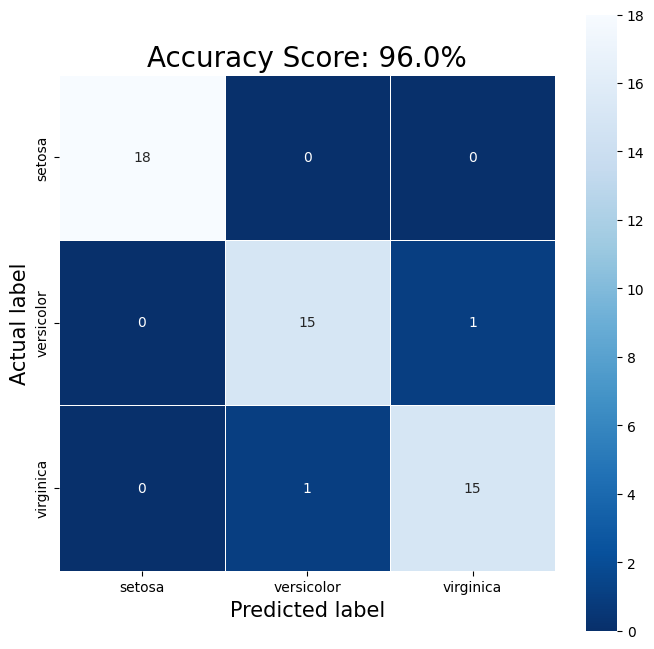

In [294]:
classifier = MSELinearClassifier()

classifier.fit(training_data, training_labels)

print(classifier.w, classifier.offset)

score = classifier.score(test_data, test_labels)

pred = classifier.predict(test_data, get_class = True)
conf_matrix = confusion_matrix(test_labels, pred)
plot_confusion_matrix(conf_matrix, score)

In [295]:
def linearClassification(classifier):
    name = classifier.__class__.__name__ 
    classifier.fit(training_data, training_labels)
    print("--------" + name + "--------")
   
    score = classifier.score(test_data, test_labels)
    print("Accuracy:", score*100, "%")

    return score, name

In [296]:
from sklearn.linear_model import LogisticRegression, Perceptron, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.svm import LinearSVC

classifiers = [LinearSVC(), LogisticRegression(), Perceptron(), PassiveAggressiveClassifier(), RidgeClassifier()]

scores = []
names = []

for c in classifiers:
    score, name = linearClassification(c)
    scores.append(score)
    names.append(name)

--------LinearSVC--------
Accuracy: 96.0 %
--------LogisticRegression--------
Accuracy: 98.0 %
--------Perceptron--------
Accuracy: 94.0 %
--------PassiveAggressiveClassifier--------
Accuracy: 94.0 %
--------RidgeClassifier--------
Accuracy: 84.0 %


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
